# Playground

This notebook walks through the main results of this project. It is kept short, so check the source code if interested.

The goal of this project was to generate single-cell images given a treatment specification. A treatment is defined by a compound and the concentration of said compound. Of special interest is to generate single-cell images specified by a treatment specification with a novelle concentration level, i.e not in the training dataset. 

We will be using a segmented version of the [BBBC021](https://bbbc.broadinstitute.org/BBBC021) dataset. The BBBC021 dataset gives the following summary:
>This image set provides a basis for testing image-based profiling methods wrt. to their ability to predict the mechanisms of action of a compendium of drugs. The image set was collected using a typical set of morphological labels and uses a physiologically relevant p53-wildtype breast-cancer model system (MCF-7) and a mechanistically distinct set of targeted and cancer-relevant cytotoxic compounds that induces a broad range of gross and subtle phenotypes.

>The images are of MCF-7 breast cancer cells treated for 24 h with a collection of 113 small molecules at eight concentrations. The cells were fixed, labeled for DNA, F-actin, and Β-tubulin, and imaged by fluorescent microscopy as described [Caie et al. Molecular Cancer Therapeutics, 2010](https://aacrjournals.org/mct/article/9/6/1913/93798/High-Content-Phenotypic-Profiling-of-Drug-Response).

We will not be interested in the mechanism of action, only the treatment type ($treatment := compound + concentration$) and the single-cell images - more on this later.

Let's start with the usual import.

In [229]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("./code")

In [230]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import logging
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

from dataset import *
from plots import *
from models import *
from utils import *

fix_seed()

## Metadata Summary

Let's load the metadata for the segmented single-cell images.

In [3]:
metadata = load_metadata()

In [4]:
metadata.head()

,Unnamed: 0,Multi_Cell_Image_Id,Multi_Cell_Image_Name,Single_Cell_Image_Id,Single_Cell_Image_Name,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration,moa
0,0,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
1,1,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
2,2,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,2,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
3,3,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,3,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
4,4,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,4,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO


In [5]:
print(f"metadata shape: {metadata.shape}")

metadata shape: (488396, 19)


Let's explore the distribution over treatments.

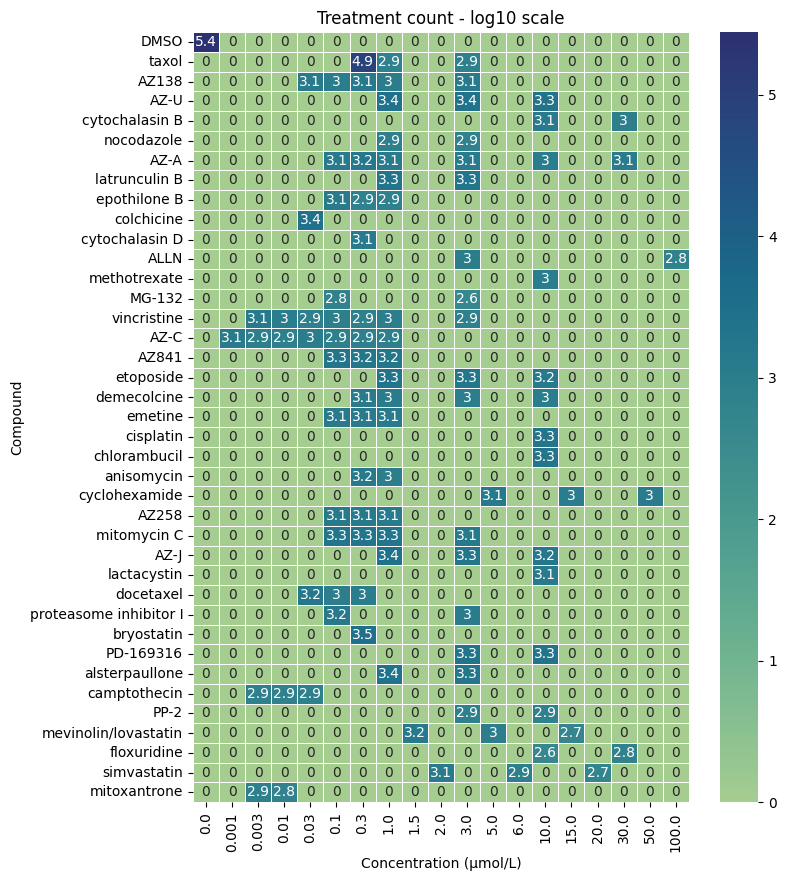

In [6]:
plot_treatment_heatmap(metadata)

Recall, the metadata also contains the field "mechanism of action" (MOA) which describes how the treatment affects the single-cell image. Let's plot that together with the compound of the treatment.

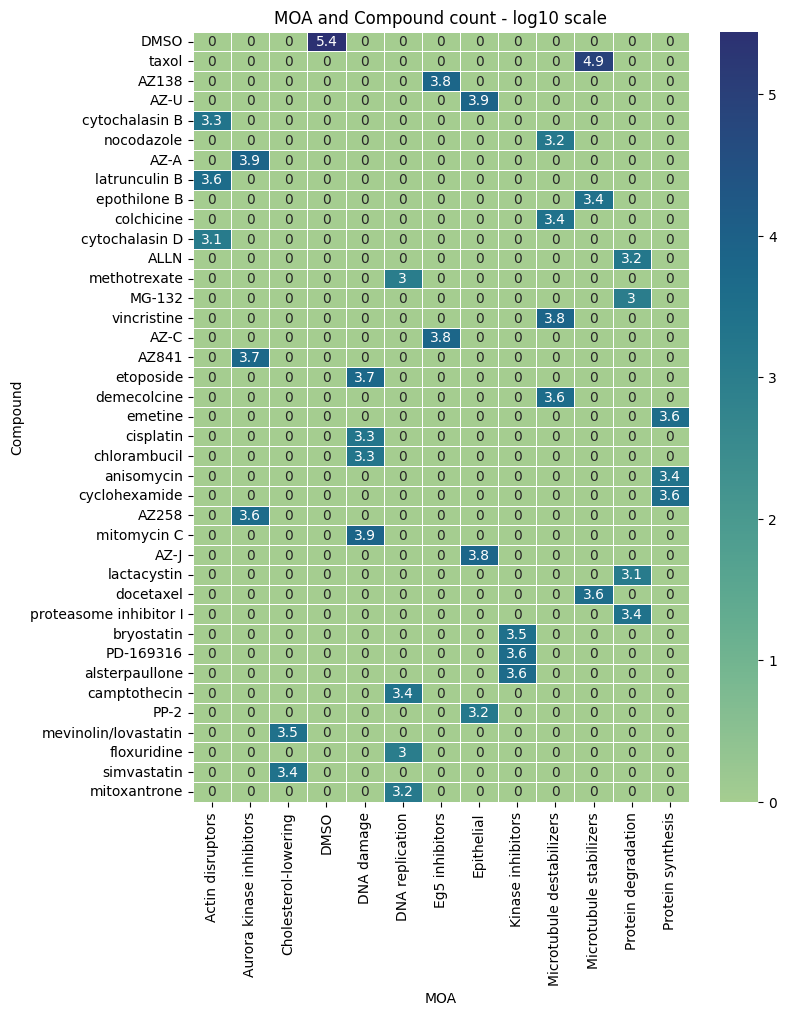

In [7]:
plot_compound_and_MOA(metadata)

A treatment always has the same mechanism of action (MOA). The BBBC021 dataset has primarly been used to predict the MOA given a picture. We will explore how well it generates single-cell images with a specified treatment and predicts the treatments of this generated images.

Notice some of the compounds have the same mechanism of action on the single-cells.

## Stratified - Subset of Dataset

We will only use a subset of the treatments. We will be needing at least 3 concentration levels for a compound, since we will impute single-cell images with none-boundary concentrations - more on this later. Notice the concentrations $0.1$, $0.3$ and $1$ appear frequently together for most compounds. So we will use compounds which have single-cell images for these 3 concentration levels.

In [9]:
whitelist = get_treatment_whitelist()
whitelist

[('AZ138', 0.1),
 ('AZ138', 0.3),
 ('AZ138', 1),
 ('AZ-A', 0.1),
 ('AZ-A', 0.3),
 ('AZ-A', 1),
 ('epothilone B', 0.1),
 ('epothilone B', 0.3),
 ('epothilone B', 1),
 ('vincristine', 0.1),
 ('vincristine', 0.3),
 ('vincristine', 1),
 ('AZ-C', 0.1),
 ('AZ-C', 0.3),
 ('AZ-C', 1),
 ('AZ841', 0.1),
 ('AZ841', 0.3),
 ('AZ841', 1),
 ('emetine', 0.1),
 ('emetine', 0.3),
 ('emetine', 1),
 ('AZ258', 0.1),
 ('AZ258', 0.3),
 ('AZ258', 1),
 ('mitomycin C', 0.1),
 ('mitomycin C', 0.3),
 ('mitomycin C', 1),
 ('DMSO', 0)]

Let's remove some of the treatments we will later impute.

In [93]:
blacklist = get_treatment_blacklist()
blacklist

[('AZ138', 0.3), ('AZ-A', 0.3), ('epothilone B', 0.3), ('vincristine', 0.3)]

In [94]:
selected = [treatment for treatment in whitelist if treatment not in blacklist]

In [97]:
stratified_metadata = stratify_metadata(metadata, 360, whitelist=selected)
stratified_images = load_images_from_metadata(stratified_metadata)

print(f"{stratified_images.shape[0]} images")

8640 images


In [98]:
stratified_metadata.head()

,Unnamed: 0,Multi_Cell_Image_Id,Multi_Cell_Image_Name,Single_Cell_Image_Id,Single_Cell_Image_Name,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration,moa
4799,4799,505,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,0,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,0,65,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,Week10_40111,Week10_200907_C08_s1_w2F9EB49AC-DE29-415C-A7A0...,Week10_40111,Week10_200907_C08_s1_w430736F56-E317-45DF-8A49...,Week10_40111,Week10_40111,C08,1,AZ138,0.1,Eg5 inhibitors
4800,4800,505,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,1,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,0,65,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,Week10_40111,Week10_200907_C08_s1_w2F9EB49AC-DE29-415C-A7A0...,Week10_40111,Week10_200907_C08_s1_w430736F56-E317-45DF-8A49...,Week10_40111,Week10_40111,C08,1,AZ138,0.1,Eg5 inhibitors
4801,4801,505,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,2,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,0,65,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,Week10_40111,Week10_200907_C08_s1_w2F9EB49AC-DE29-415C-A7A0...,Week10_40111,Week10_200907_C08_s1_w430736F56-E317-45DF-8A49...,Week10_40111,Week10_40111,C08,1,AZ138,0.1,Eg5 inhibitors
4802,4802,505,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,3,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,0,65,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,Week10_40111,Week10_200907_C08_s1_w2F9EB49AC-DE29-415C-A7A0...,Week10_40111,Week10_200907_C08_s1_w430736F56-E317-45DF-8A49...,Week10_40111,Week10_40111,C08,1,AZ138,0.1,Eg5 inhibitors
4803,4803,505,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,4,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,0,65,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,Week10_40111,Week10_200907_C08_s1_w2F9EB49AC-DE29-415C-A7A0...,Week10_40111,Week10_200907_C08_s1_w430736F56-E317-45DF-8A49...,Week10_40111,Week10_40111,C08,1,AZ138,0.1,Eg5 inhibitors


The paper, [Capturing Single-Cell Phenotypic Variation
via Unsupervised Representation Learning - Lafarge et al](http://proceedings.mlr.press/v102/lafarge19a/lafarge19a.pdf) normalize single-cell images channel-wise, so will we. It is plausible that the signal strength of an image is different between single-cell image batches - and channels. Thus, such a normalization is not unreasonable. 

In [99]:
stratified_images = normalize_image_channel_wise(stratified_images)

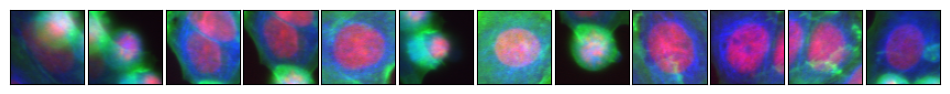

In [100]:
plot_images(stratified_images[:12])

Notice in the above segmented single-cell images (such image 2 and 3), some these images unfornately still contain multiple single-cells due to the proximity of the single-cells in the original unsegmented image. Fortunately cells in the same segmented image has undergone the same treatment.

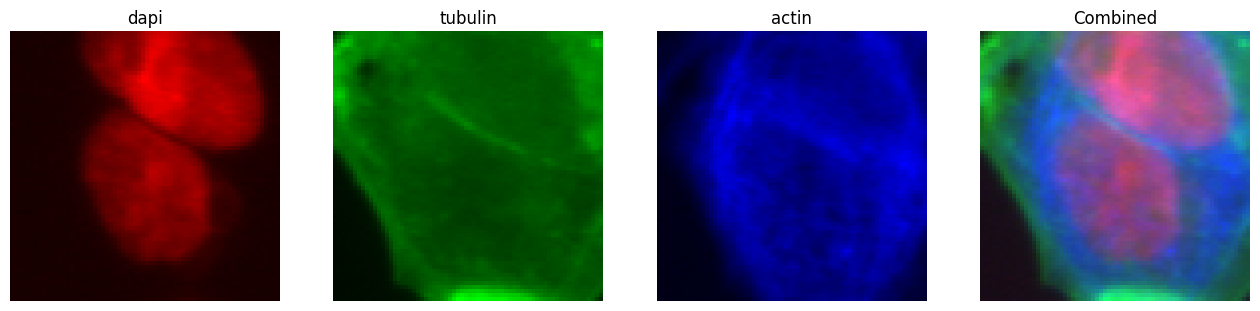

In [101]:
plot_channels(stratified_images[2])

## Conditional Diffusion Model - Training

Let's train a conditional diffusion model to generate single-cell images given a treatment specification.
The conditional diffusion model uses a conditional U-net behind the scenes. Additionally, classifier-free guidance is used to make the diffusion model conditional.

In [102]:
compound_types = extract_compound_types(whitelist)
concentration_types = extract_concentration_types(whitelist)

In [103]:
train_metadata = stratified_metadata
train_images = stratified_images

In [123]:
train_images = normalized_to_pseudo_zscore(train_images)
train_images = crop_images(train_images)

In [ ]:
train_conditional_diffusion_model(train_metadata, train_images, compound_types, concentration_types, epochs=2, epoch_sample_times=2, batch_size=2)

## Conditional Diffusion Model - Load pretrained

Actually, we have already trained a conditional diffusion model. Let's load it and sample some images.

In [30]:
treatments_to_sample = [("DMSO", 0), ("epothilone B", 0.3), ("AZ841", 1)] # (compound, concentration)

In [10]:
compound_types = extract_compound_types(whitelist)
concentration_types = extract_concentration_types(whitelist)

compound_to_id, _ = get_label_mappings(compound_types)
concentration_to_id, _ = get_label_mappings(concentration_types)

In [22]:
unet = UNet_conditional(len(compound_types), len(concentration_types))
unet.load_state_dict(torch.load("./results/DDPM_Conditional/weights/ckpt1.pt", map_location=torch.device('cpu')))
diffusion = Diffusion_conditional()

compounds = [treatment[0] for treatment in treatments_to_sample]
compounds = torch.from_numpy(np.array([compound_to_id[c] for c in compounds]))

concentrations = [treatment[1] for treatment in treatments_to_sample]
concentrations = torch.from_numpy(np.array([concentration_to_id[c] for c in concentrations]))

sampled_images = diffusion.sample(unet, N_images=len(treatments_to_sample), y_compounds=compounds, y_concentrations=concentrations)

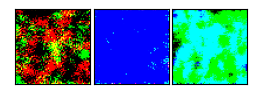

In [48]:
plot_images(sampled_images)

## Conditional Diffusion Model - Training results

Let's also see how this pre-trained conditional diffusion model improved throughout training. Here we sample a single-cell image for each of the compounds at a fixed concentration over a few epochs.

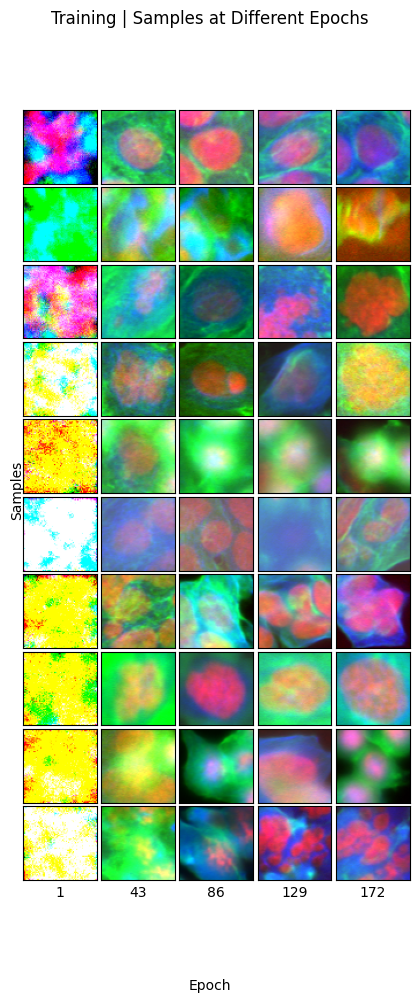

In [3]:
epoch_images, epochs = load_epoch_images("./results/DDPM_Conditional/training")
plot_epoch_sample_series(epoch_images, epochs)

Great, it goes from a noisy image to a single-cell image!

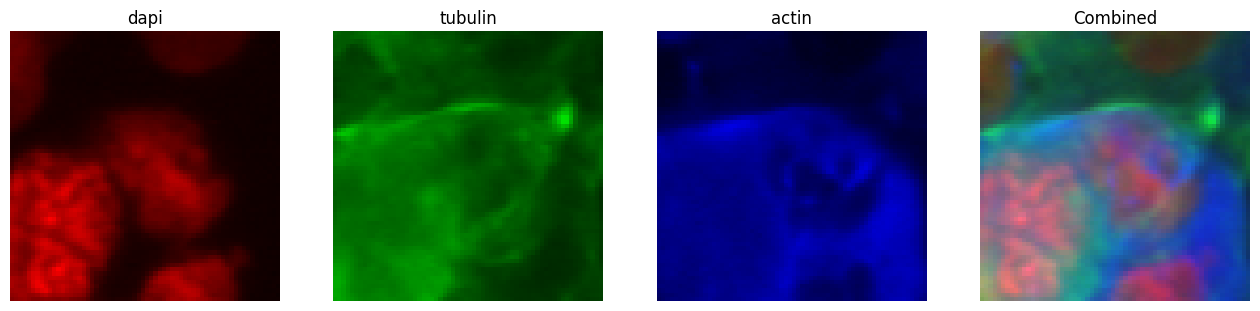

In [24]:
plot_channels(epoch_images[-1][0])

## Evaluation

Now it's time to evaluate the generated images. We will use some pre-generated images, since diffusion models are fairly slow at generating images. We have trained a model to predict the compound of a single-cell image and the concentration. We will use this model to evalulate the imputation performance of the conditional diffusion model.

In [19]:
path = "./results/DDPM_Conditional/sampling/"
sample_metadata = load_dict(os.path.join(path, "metadata.pkl"))
sample_images = torch.tensor(np.load(os.path.join(path, "images.npy"))).float()

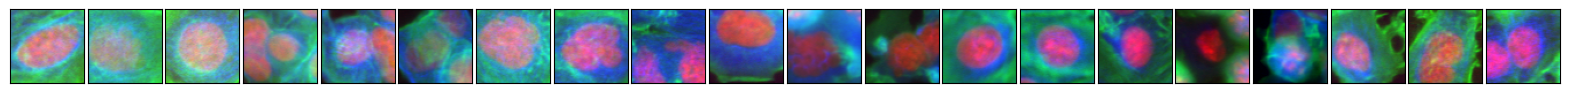

In [20]:
plot_images(sample_images[:20])

## Compound classification

In [21]:
target_compounds = np.array([compound_to_id[treatment[0]] for treatment in sample_metadata["treatments"]])
target_compounds = torch.tensor(target_compounds)

In [22]:
compound_model = Compound_classifier2(len(compound_types))
compound_model.load_state_dict(torch.load("./results/Compound_Classifier/weights/ckpt.pt", map_location="cpu"))

<All keys matched successfully>

In [23]:
compound_model.eval()
pred_compounds = compound_model(sample_images)
pred_compounds = pred_compounds.max(1)[1]

In [24]:
acc = accuracy(target_compounds, pred_compounds)
print(f"Accuracy: {acc*100:.1f}%")

Accuracy: 13.1%


In [39]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

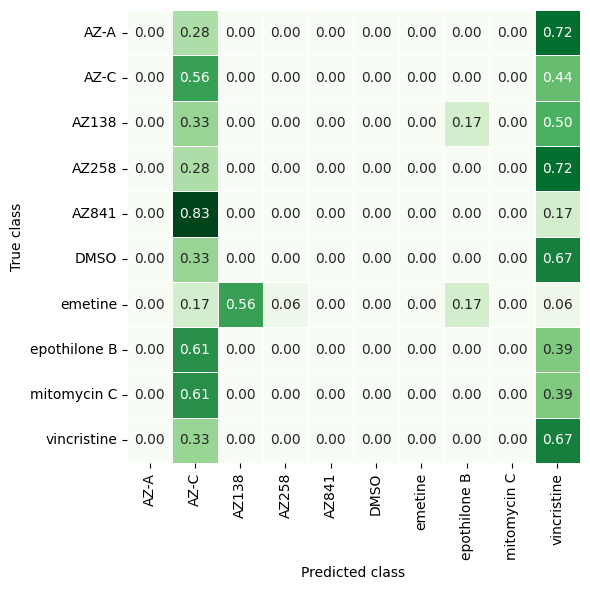

In [26]:
confusion_matrix = compute_confusion_matrix(target_compounds, pred_compounds)

x_labels = compound_types
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(ax=plt.gca(), data=normalize(confusion_matrix, 'true'),
    annot=True, linewidths=0.5, cmap="Greens", cbar=False, fmt=".2f",
    xticklabels=x_labels, yticklabels=y_labels)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

## Concentration classification

In [31]:
target_concentrations = np.array([concentration_to_id[treatment[1]] for treatment in sample_metadata["treatments"]])
target_concentrations = torch.tensor(target_concentrations)

In [36]:
concentration_model = Concentration_classifier2(len(concentration_types))
concentration_model.load_state_dict(torch.load("./results/Concentration_Classifier/weights/ckpt.pt", map_location="cpu"))

<All keys matched successfully>

In [37]:
concentration_model.eval()
pred_concentrations = concentration_model(sample_images)
pred_concentrations = pred_concentrations.max(1)[1]

In [38]:
acc = accuracy(target_concentrations, pred_concentrations)
print(f"Accuracy: {acc*100:.1f}%")

Accuracy: 31.0%


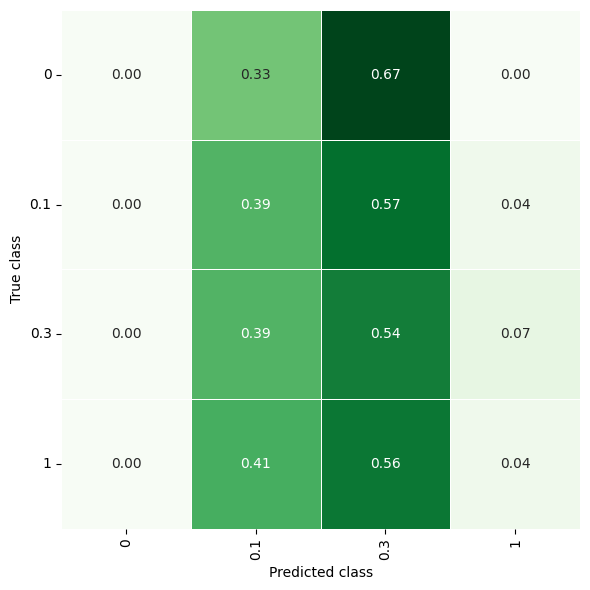

In [41]:
confusion_matrix = compute_confusion_matrix(target_concentrations, pred_concentrations)

x_labels = concentration_types
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(ax=plt.gca(), data=normalize(confusion_matrix, 'true'),
    annot=True, linewidths=0.5, cmap="Greens", cbar=False, fmt=".2f",
    xticklabels=x_labels, yticklabels=y_labels)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

We have now arrivied to the end of the main results of this project.

In the following section, a few additional details are shared.

# Miscellaneous

Let's now look at how well the compound and concentration classification models perform in terms of prediction accuracy. Recall, these classification models were used to evaluate the single-cell images generated by the conditional diffusion model. The classification models are mainly made out of a few convolutional layers, max-pooling layers and ending with a feedforward layers.

## Compound Classifier Results

In [5]:
classifier_training_data = load_dict("./results/Compound_Classifier/training/train_results.pkl")

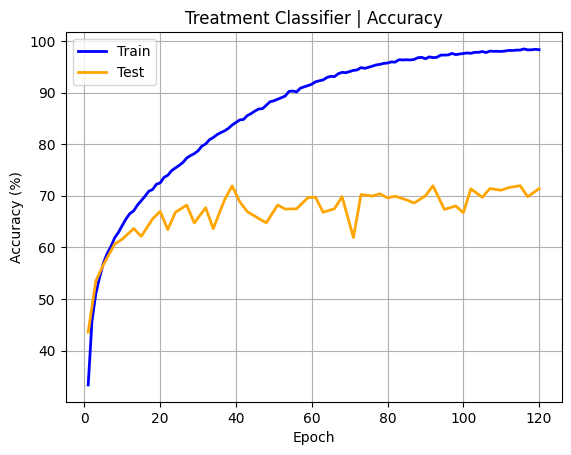

In [6]:
plot_treatment_classifier_accuracy(classifier_training_data)

## Concentration Classifier Results

In [45]:
classifier_training_data = load_dict("./results/Concentration_Classifier/training/train_results.pkl")

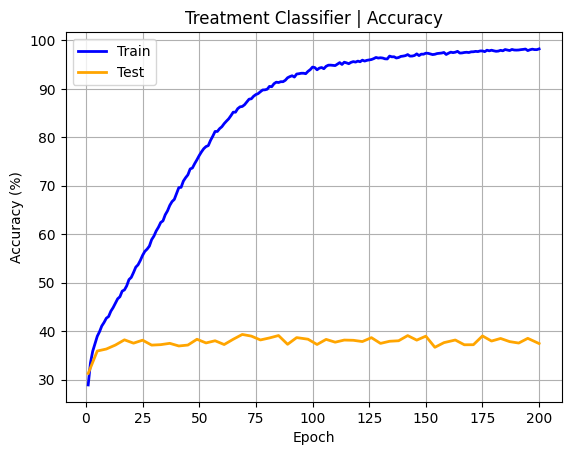

In [46]:
plot_treatment_classifier_accuracy(classifier_training_data)

## VAE

In [199]:
vae_training_data = load_dict("./results/VAE_predictor/training/train_results.pkl")

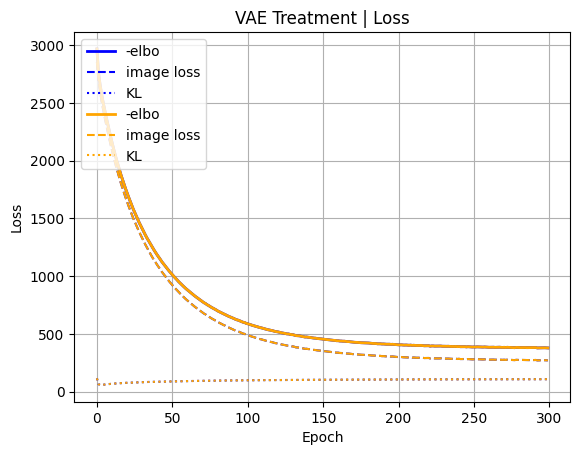

In [238]:
plot_VAE_classifier_loss(vae_training_data)

In [225]:
latent_features = 256
vae = CytoVariationalAutoencoder(np.array([3, 64, 64]), latent_features)
vae.load_state_dict(torch.load("./results/VAE_predictor/weights/ckpt.pt", map_location=torch.device('cpu')))
vae.eval();

08:05:38 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


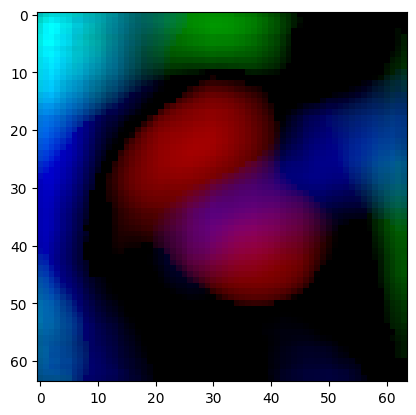

In [226]:
noise = torch.normal(mean=torch.zeros(latent_features), std=torch.ones(latent_features))
generated_image = vae.decoder(noise[None])
plot_image(generated_image[0].detach())

08:05:38 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
08:05:38 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


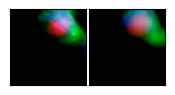

In [227]:
vae_parse = vae(train_images[0][None])
p = torch.concat([train_images[0][None], vae_parse["x_hat"].detach()])
plot_images(p)

In [ ]:
# @TODO: 1-NN for compound and concentration